In [1]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine
raw_engine = author.raw_engine

각 종목 별로 유의미한 피쳐들을 선정해 사용한다. </br>
* BTC: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d, Rsi
* TLT: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d
* QQQ: Macd_signal, Vwap, pct, Moment, Rsi, Macd_Gap
* GCF: Macd_signal, Vwap, pct, Moment

* Vix나 USDT 같은 지표 들은 그냥 값을 그대로 활용했다. 부가적인 요소들을 사용하지 않았다.

In [2]:
def get_df(ticker):
    df = pd.read_sql(f"SELECT * FROM {ticker}_1d",engine) #로컬 db에서 테이블 가져옴
    df.set_index(df.columns[0], inplace=True)
    return df

bit_df = get_df("BTCUSD")
qqq_df = get_df("QQQ")
tlt_df = get_df("TLT")
gld_df = get_df("GCF")


비트코인의 데이터 만으로 가격을 예측 할 수 있을까? </br>
비트코인은 다른 자산과의 상관관계도 높은 편이고 과적합을 피하기 위해서라도 다른 자산의 피쳐를 활용하는 것은 </br>
현명한 생각으로 보여진다.

In [3]:
bit_fedf = bit_df[["Macd_Signal", "Vwap", "Pct", "Moment", "Fast_d", "Rsi","Price"]]
tlt_fedf = tlt_df[["Moment"]]
qqq_fedf = qqq_df[["Moment"]]
gld_fedf = gld_df[["Moment"]]

금, 미국 장기채, 나스닥, 금선물의 추세지표를 가져온다.

In [4]:
vix = pd.read_sql("SELECT Date, Close FROM VIX_1d", raw_engine)
vix.set_index(vix.columns[0], inplace=True)
usd = pd.read_sql("SELECT Date, Close FROM DXF_1d", raw_engine)
usd.set_index(usd.columns[0], inplace=True)


VIX(변동성 지표)와 달러 인덱스도 가져온다.

In [5]:
data_frames = [bit_fedf, tlt_fedf, qqq_fedf, gld_fedf, vix, usd]
for df, ticker in zip(data_frames, ["BTC","TLT","QQQ","GCF","VIX","USD"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [6]:
from functools import reduce
df_merged = reduce(lambda left,right: pd.merge(left, right, right_index=True, left_index=True,
                                            how='inner'), data_frames)

df_merged

,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,BTC_Price,TLT_Moment,QQQ_Moment,GCF_Moment,VIX_Close,USD_Close
2015-11-11,22.953,270.309,-7.641,1.091,6.247,46.116,311.084,0.979,1.045,0.948,16.059999,99.157997
2015-11-12,20.278,270.823,8.701,1.136,8.413,52.819,338.152,0.981,1.040,0.946,18.370001,98.711998
2015-11-13,17.839,271.171,-0.414,1.130,7.438,52.455,336.753,0.983,1.030,0.946,20.080000,99.097000
2015-11-16,10.614,271.938,3.306,1.107,5.277,50.911,330.751,0.982,1.038,0.947,18.160000,99.538002
2015-11-17,9.495,272.266,1.313,1.103,4.457,52.099,335.094,0.983,1.039,0.940,18.840000,99.699997
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,-1043.582,27870.820,0.157,62.402,10.313,41.726,38529.328,1.023,2.220,1.300,32.340000,103.765999
2022-05-03,-1081.377,27877.427,-2.022,61.989,7.911,38.879,37750.453,1.026,2.217,1.302,29.250000,103.496002
2022-05-04,-943.277,27887.285,5.160,61.846,17.622,48.366,39698.371,1.028,2.231,1.302,25.420000,102.594002
2022-05-05,-1073.475,27897.073,-7.867,61.371,16.616,38.143,36575.141,1.015,2.205,1.304,31.200001,103.802002


In [32]:
test_df, df_merged = df_merged[-100:], df_merged[:-100]

모델을 학습 시켜보자. 자산을 추가함으로써 내가 얻고 싶은 것들은 아래와 같다.
* 모델의 과적합 해소
* 모델이 폭락, 폭등에 조금이나마 적응
* 특정 기간에만 잘 맞는 현상 제거

In [51]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=1,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=1,random_state=42,fit_intercept=True))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=1,random_state=42,fit_intercept=True,l1_ratio=0.5))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [9]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['BTC_Price'], axis=1).iloc[:-1]
    y = df['BTC_Price'].iloc[1:]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [52]:
train_X, test_X, train_y, test_y = create_train_data(df_merged)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)
rf_model.fit(train_X, train_y)

Pipeline(steps=[('min_max', MinMaxScaler()),
                ('machine',
                 RandomForestRegressor(max_depth=2000, oob_score=True,
                                       random_state=42))])

In [11]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar(figsize=(12,8))

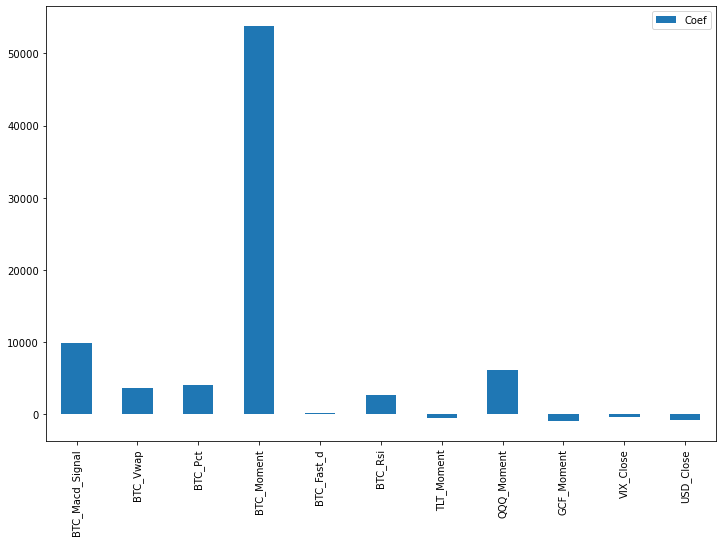

In [12]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

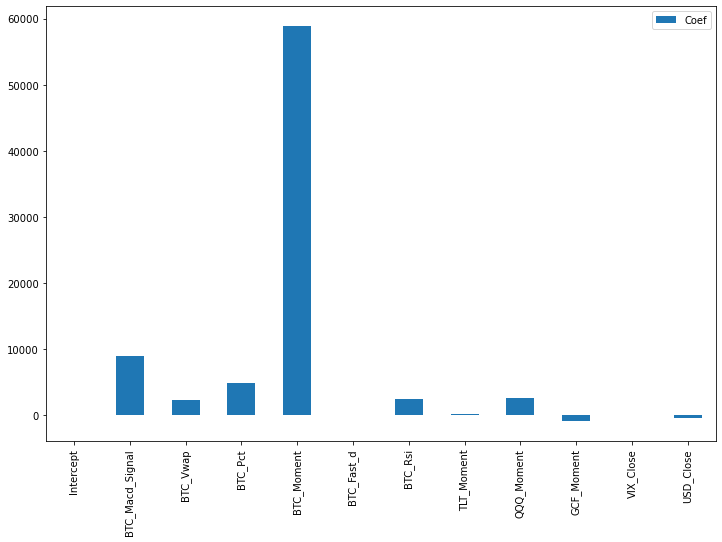

In [13]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns,True)

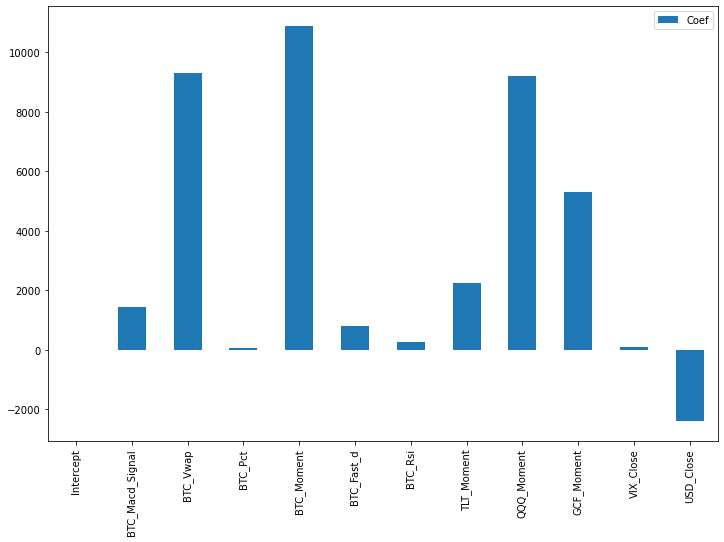

In [14]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)


In [34]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1,0.1,0.03,0.01,0.001]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha

ridge_model.set_params(poly_features__degree=3)
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

lasso_model.set_params(poly_features__degree=3)
l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

elastic_model.set_params(poly_features__degree=3)
e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



mse: 16058438.904844481, alpha: 1000
mse: 6430393.07548316, alpha: 300
mse: 3653306.7527422784, alpha: 100
mse: 2445799.624081287, alpha: 30
mse: 1827286.63122532, alpha: 10
mse: 1189528.1084215736, alpha: 1
mse: 1073578.493281866, alpha: 0.1
mse: 1078980.2197778504, alpha: 0.03
mse: 1108458.1178414116, alpha: 0.01
mse: 1231074.710905607, alpha: 0.001
mse: 18313214.79953165, alpha: 1000
mse: 4304213.407813079, alpha: 300
mse: 1941767.548365377, alpha: 100
mse: 1523539.8156752198, alpha: 30
mse: 1380800.7848679407, alpha: 10
mse: 1109607.6926492727, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188292436.1150645, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394142235.9906398, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1084891.3441948793, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464941049.75880665, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1191098.4199354548, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489684438.927898, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1242969.8702390282, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498414487.1692158, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394142235.9906398, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1279193.0322401612, alpha: 0.001
mse: 243321584.66726235, alpha: 1000
mse: 232211435.6114244, alpha: 300
mse: 204683518.52234563, alpha: 100
mse: 141165008.95726866, alpha: 30
mse: 70078740.10303324, alpha: 10
mse: 9664182.253979629, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3727650182.0987024, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 2909094.643743149, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2333795702.817084, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 2052523.5422606638, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550487055.4925237, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1553089.6277926343, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 828856647.7056565, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


mse: 1157802.6228895828, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 828856647.7056565, tolerance: 28874760.561869033
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator', ElasticNet(alpha=0.001, random_state=42))])

In [16]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [53]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)
rf_pred = rf_model.predict(test_X)


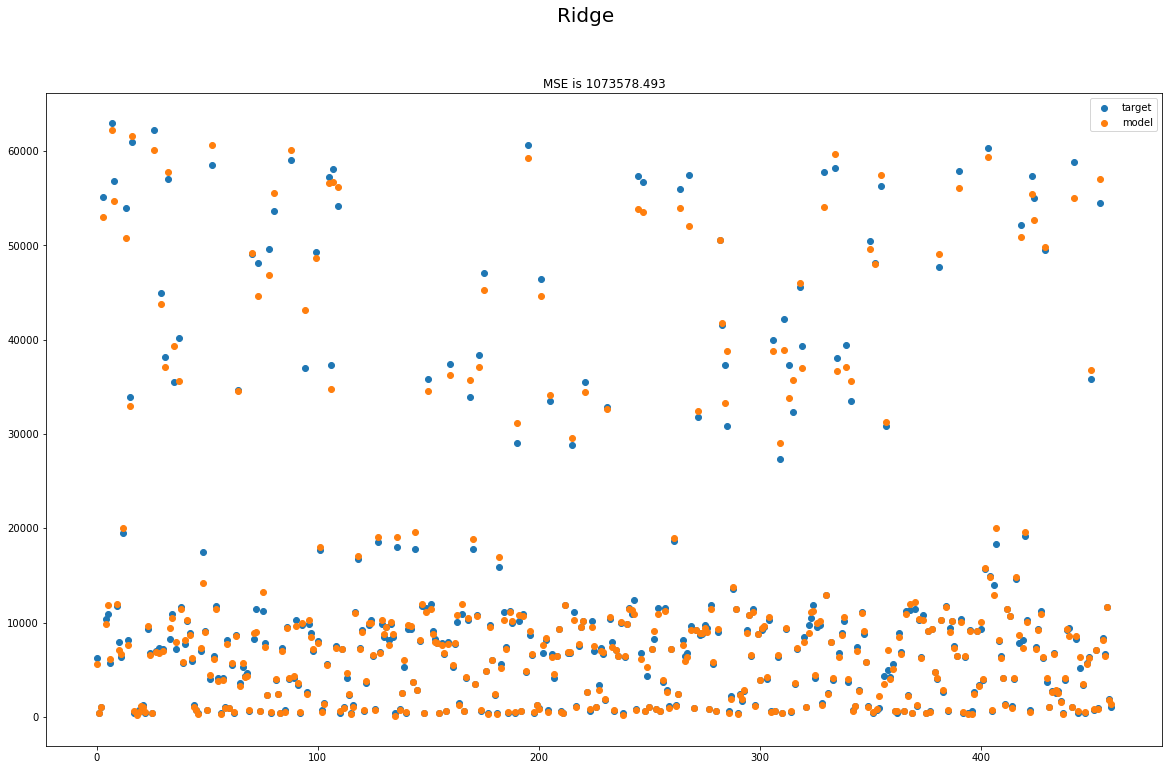

In [36]:
visualize(r_pred, test_y, "Ridge")

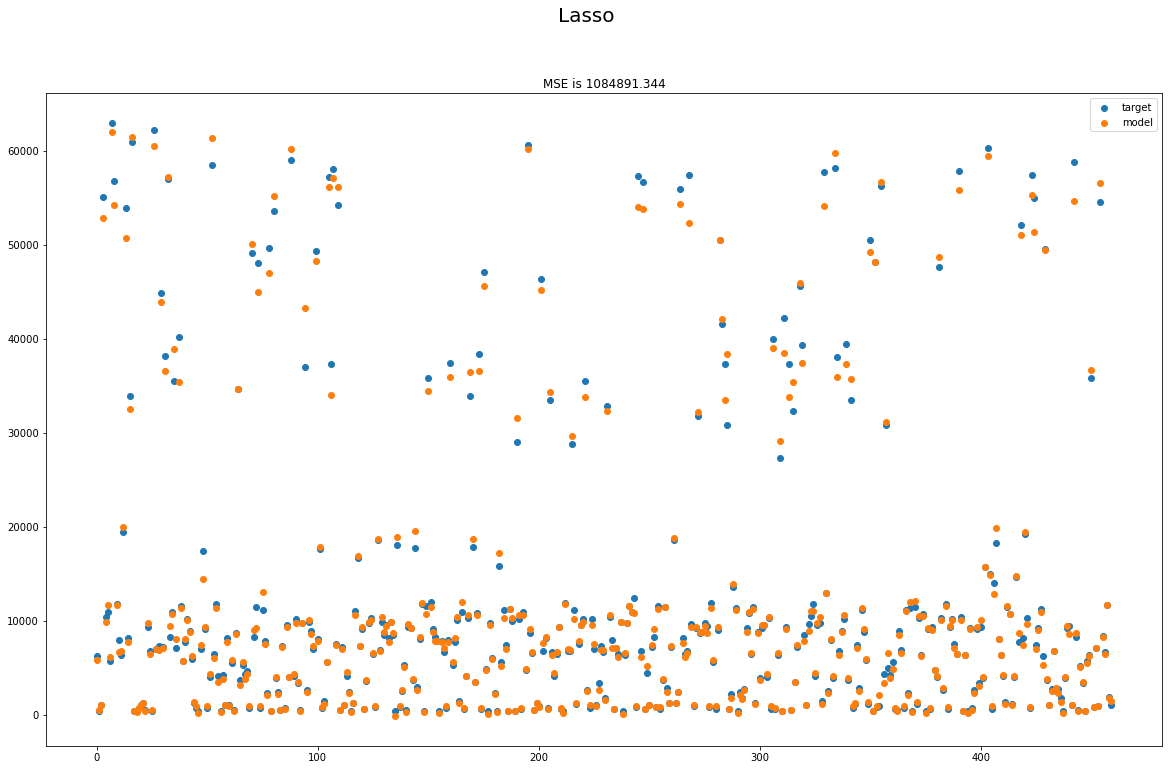

In [37]:
visualize(l_pred, test_y, "Lasso")


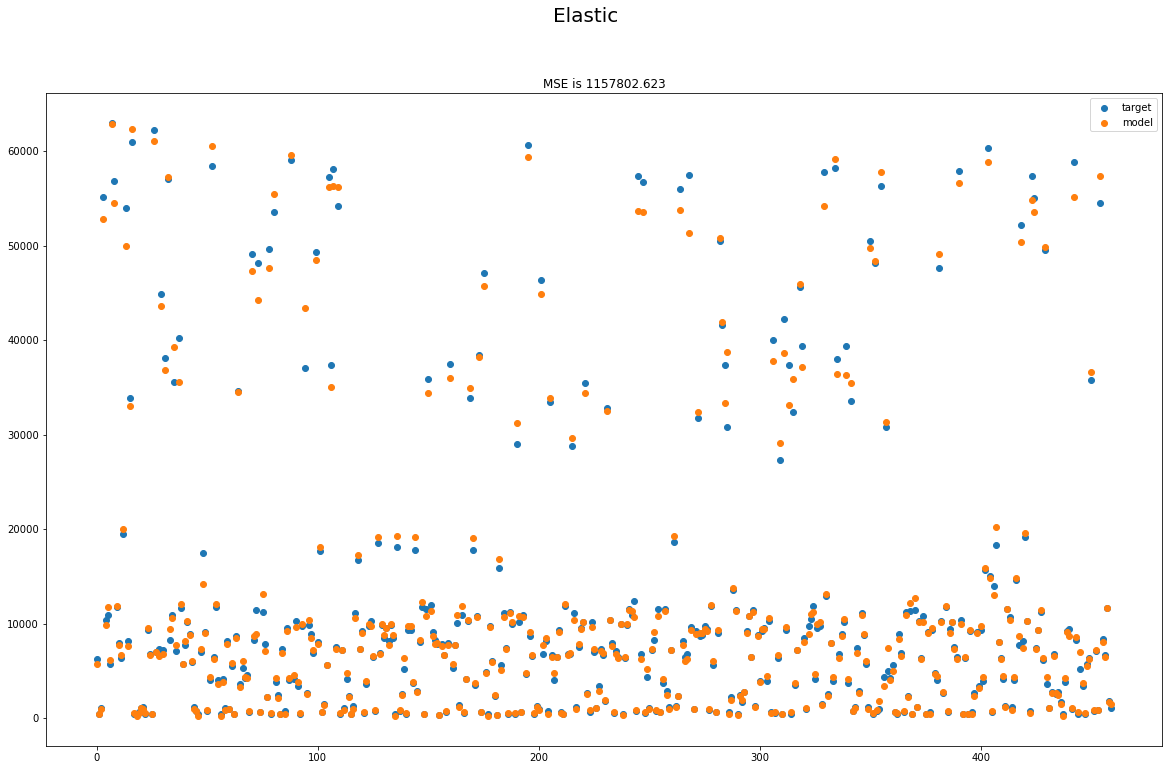

In [38]:
visualize(e_pred, test_y, "Elastic")

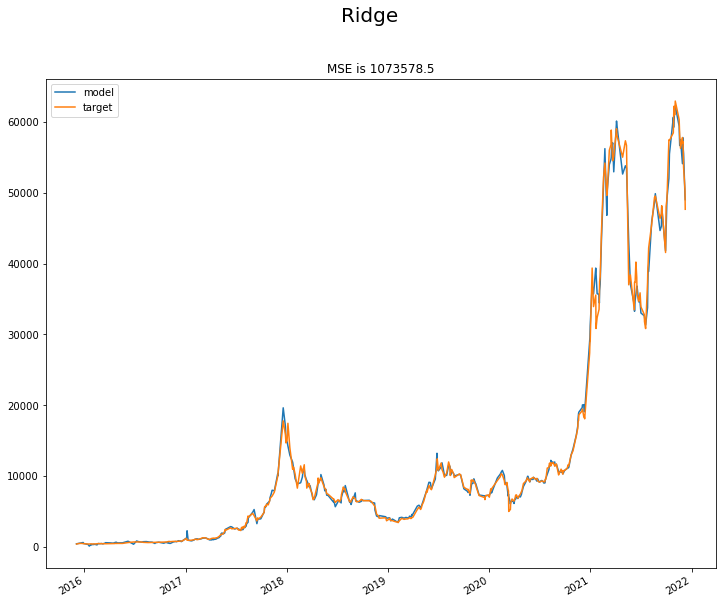

In [39]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


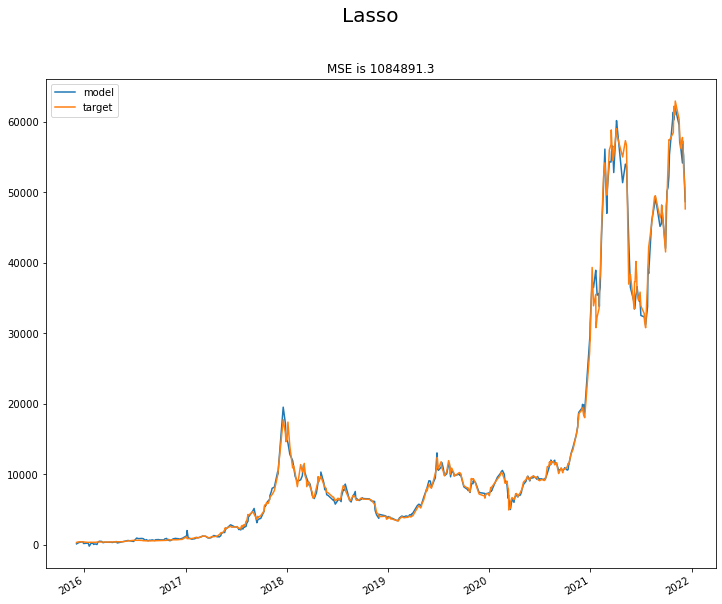

In [40]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")


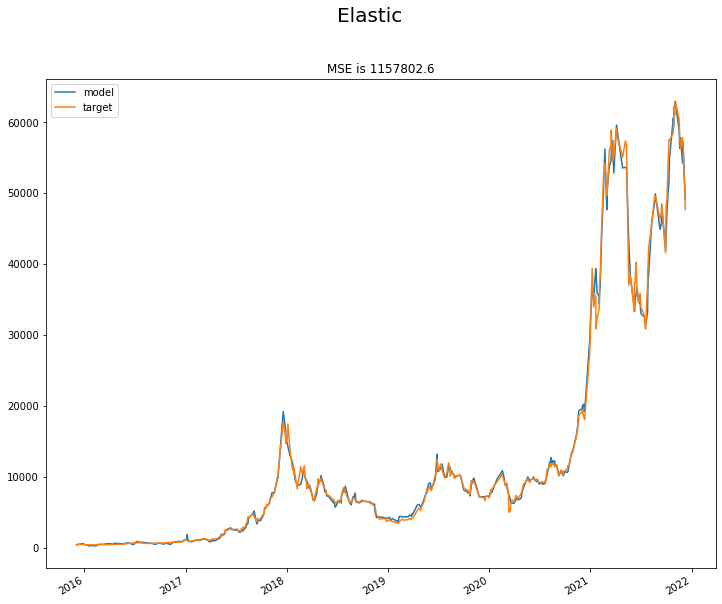

In [41]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


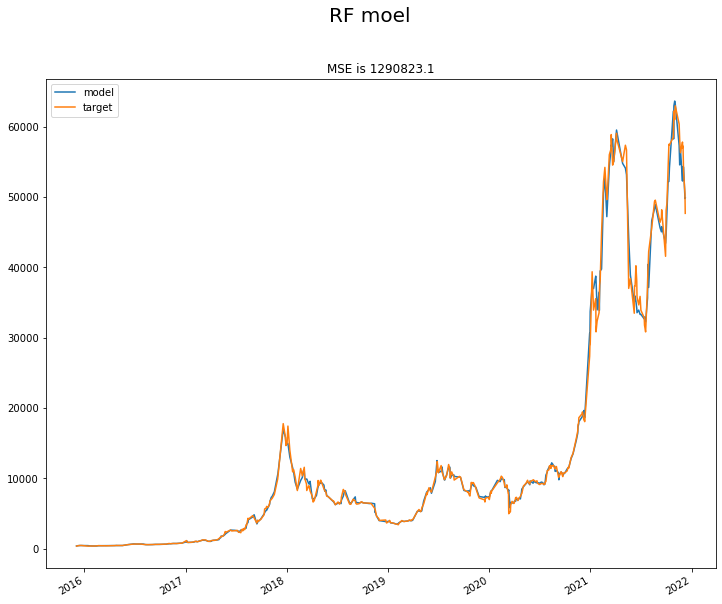

In [54]:
eval_model.visualize_plot(rf_pred, test_y, "RF model")

근래 존재하던 100거래일 동안의 모델의 퍼포먼스를 살펴보자
* 100일 간의 데이터는 학습하지 않은 데이터이다.

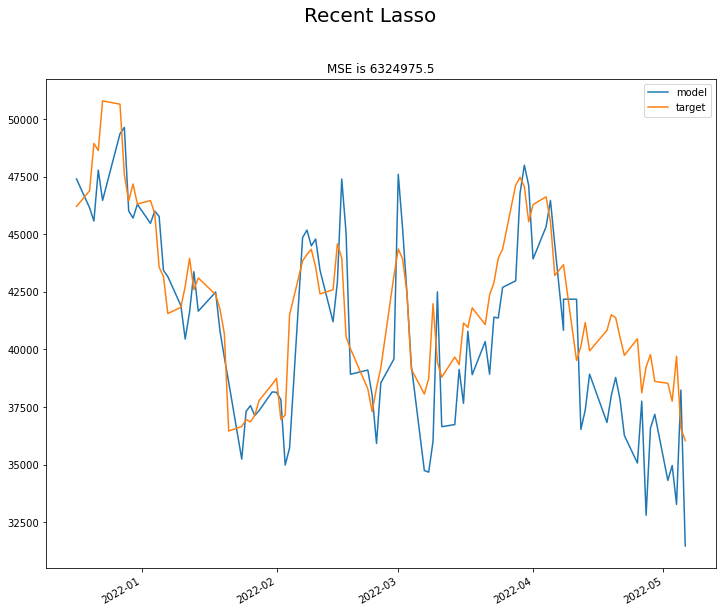

In [42]:
test_x = test_df.drop('BTC_Price',axis=1).iloc[:-1]
test_y = test_df['BTC_Price'].iloc[1:]
l_test_pred = lasso_model.predict(test_x)
eval_model.visualize_plot(l_test_pred, test_y, name="Recent Lasso")

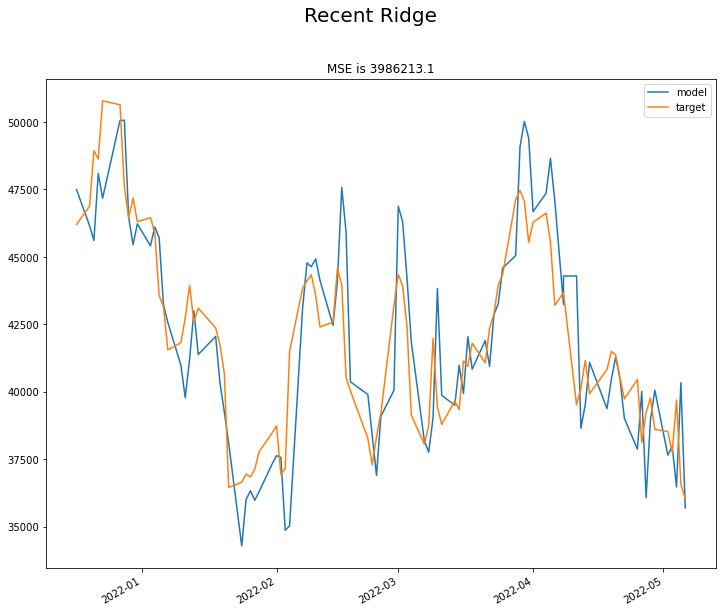

In [44]:
r_test_pred = ridge_model.predict(test_x)
eval_model.visualize_plot(r_test_pred, test_y, name="Recent Ridge")


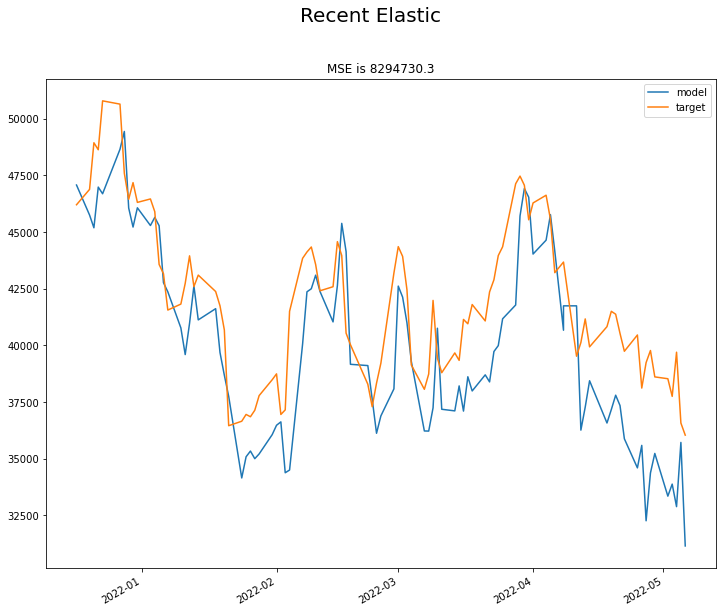

In [45]:
e_test_pred = elastic_model.predict(test_x)
eval_model.visualize_plot(e_test_pred, test_y, name="Recent Elastic")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df_merged.drop(['BTC_Price'], axis=1).iloc[1:]
train_y = df_merged['BTC_Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        result.append([mae, mse, score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score"]))

In [47]:
cv_result[0] #ridge

,mae,mse,score
0,33.066036,49.338590,0.773775
1,44.635843,49.173666,-1.362108
2,41.535259,50.975984,0.793101
3,94.396217,124.064360,0.699188
4,608.477288,785.679036,-0.277716
5,1055.505833,1939.894412,0.620146
6,6708.399151,7087.862916,-4.209682
7,1124.911407,1282.576434,-0.459835
8,176.391615,236.951211,0.811545
9,565.609207,634.883380,0.698796


In [48]:
cv_result[1] #lasso

,mae,mse,score
0,39.199346,48.707741,0.779523
1,35.188907,39.892294,-0.554578
2,41.633990,49.816083,0.802409
3,98.816933,155.067187,0.530062
4,133.677731,156.448395,0.949338
5,760.033670,1183.516749,0.858613
6,4952.248837,5189.958595,-1.793241
7,1211.459048,1331.719638,-0.573848
8,160.187294,207.575902,0.855375
9,555.926551,627.331339,0.705919


In [49]:
cv_result[2] #elastic

,mae,mse,score
0,34.501125,51.960765,0.749089
1,44.090999,48.543704,-1.301974
2,40.536340,50.431697,0.797495
3,58.290211,80.779427,0.872473
4,637.196409,790.949521,-0.294916
5,1122.475561,1548.640426,0.757919
6,5938.757493,6311.204626,-3.130523
7,1174.687120,1318.106392,-0.541836
8,354.530392,409.541720,0.437028
9,643.085982,733.922197,0.597493


In [50]:
for name, cv in zip(["Ridge","Lasso","Elastic"], cv_result):
    print(f"{name}:\n {cv.mean()}")

Ridge:
 mae      1664.830749
mse      2093.072930
score       0.072104
dtype: float64
Lasso:
 mae      1592.929465
mse      2058.307794
score       0.272585
dtype: float64
Elastic:
 mae      1273.525167
mse      1571.901145
score       0.278711
dtype: float64


엘라스틱 모델의 퍼포먼스가 가장 괜찮게 나왔다. </br>
새로운 자산을 추가하는 것이 그다지 큰 효과를 발휘하고 있지 않다는 생각이 든다.</br>
* 이는 아마 주식 데이터는 평일에만 열리게 되므로 주말 간의 데이터가 손실 된 것이 어느정도 기여를 하지 않나 싶다.

In [50]:
import joblib
joblib.dump(lasso_model, "Lasso_total.pkl")
joblib.dump(ridge_model, "Ridge_total.pkl")

['Ridge_total.pkl']